In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm

In [42]:
common_path = '/content/drive/My Drive/Colab Notebooks/spec2006-perf-simulations/'
df_list = []
j = 0
for i in range(1, 7) :
    df_list.append(pd.read_csv(common_path+'401.bzip2/yinputs/bzip2_input' + str(i) + '.csv'))
    for k in list(df_list[-1]) :
        df_list[-1][k] = pd.to_numeric(df_list[-1][k], errors='coerce')       # convert all strings to NaN
    df_list[-1].fillna(df_list[-1].median(), inplace=True)            # convert all NaN to median of the corresponding column

df = pd.concat(df_list)
df.shape

(4573, 30)

In [60]:
df

,Timestamp,inst_retired.any,cycles,cpu_clk_unhalted.thread,cpu_clk_unhalted.ref_tsc,msr/tsc/,fp_arith_inst_retired.scalar_single,fp_arith_inst_retired.scalar_double,fp_arith_inst_retired.128b_packed_double,fp_arith_inst_retired.128b_packed_single,fp_arith_inst_retired.256b_packed_double,fp_arith_inst_retired.256b_packed_single,cpu_clk_thread_unhalted.one_thread_active,cpu_clk_thread_unhalted.ref_xclk_any,cpu_clk_unhalted.ref_tsc:u,uops_issued.any,uops_retired.retire_slots,icache_64b.iftag_hit,icache_64b.iftag_miss,idq.dsb_uops,lsd.uops,idq.mite_uops,idq.ms_uops,l1d_pend_miss.pending,l1d_pend_miss.pending_cycles_any,l1d_pend_miss.pending_cycles,mem_load_retired.l1_miss,mem_load_retired.fb_hit,uops_executed.thread,uops_executed.core_cycles_ge_1
0,0.100247,3.356049e+08,307040425.0,238750472.0,268258487.0,269535095.0,0.0,0.0,0.0,0.0,0.0,0.0,2349186.0,2369699.0,50375978.0,265174088.0,281770364.0,37342124.0,29440.0,7.509810e+07,0.0,124475514.0,156226078.0,7.332424e+06,6922043.0,6800167.0,74591.0,196353.0,350521420.0,139314921.0
1,0.200654,3.044350e+08,308563649.0,308525660.0,270253526.0,271710224.0,0.0,0.0,0.0,0.0,0.0,0.0,2328440.0,2399823.0,50586015.0,334345043.0,263697581.0,47804423.0,48714.0,7.691004e+07,0.0,149909401.0,154255465.0,1.840790e+07,22988770.0,13448786.0,153771.0,479623.0,323136884.0,131946805.0
2,0.301061,2.875541e+08,308257398.0,307770784.0,270636533.0,271486068.0,0.0,4.0,4.0,3.0,0.0,0.0,1063651.0,2393286.0,46769069.0,322084829.0,254140027.0,45601457.0,36047.0,7.790440e+07,0.0,136886109.0,162775358.0,2.216604e+07,23719928.0,21248859.0,161878.0,487817.0,275698542.0,137825133.0
3,0.401404,1.495628e+08,308834256.0,308662818.0,270409366.0,271557277.0,0.0,0.0,0.0,0.0,0.0,0.0,2372495.0,2390320.0,180986107.0,461588429.0,70568194.0,90489142.0,59336.0,7.051721e+07,0.0,105387313.0,140058274.0,2.045280e+09,186198335.0,185303137.0,1391663.0,12656000.0,87149118.0,37164984.0
4,0.501747,1.085465e+09,309369320.0,309342151.0,271614928.0,271862725.0,0.0,0.0,0.0,0.0,0.0,0.0,2310275.0,2395798.0,269907472.0,821704558.0,592722335.0,185934685.0,13925.0,9.346707e+08,0.0,1402659.0,329400.0,1.304609e+08,4912810.0,4912806.0,5778016.0,5415026.0,734473417.0,223424597.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,71.340256,5.893365e+08,307044587.0,308461942.0,271480135.0,271635190.0,0.0,0.0,0.0,0.0,0.0,0.0,2362613.0,2391550.0,269761119.0,397928277.0,321451442.0,66415780.0,15326.0,3.990328e+08,0.0,2755043.0,1519496.0,4.138892e+07,24723933.0,1500130.0,1311713.0,202408.0,394051341.0,154076948.0
711,71.440573,6.816701e+08,309195298.0,307872350.0,271133212.0,271725771.0,0.0,0.0,0.0,0.0,0.0,0.0,2255419.0,2390830.0,269540730.0,853753467.0,273459281.0,218225208.0,19644.0,1.003358e+09,0.0,13141560.0,381728.0,1.928855e+08,211391494.0,209088556.0,4916331.0,39985.0,678583578.0,208465036.0
712,71.540879,4.924719e+08,309244934.0,309021756.0,271420285.0,271704328.0,0.0,0.0,0.0,0.0,0.0,0.0,2345790.0,2394992.0,270246089.0,504714701.0,325745488.0,117958060.0,22865.0,9.813217e+08,0.0,7040324.0,523027.0,8.681170e+06,865646.0,865647.0,238744.0,119623.0,182786448.0,98300539.0
713,71.641206,2.675997e+08,309274660.0,308558776.0,271677230.0,271824305.0,0.0,0.0,0.0,0.0,0.0,0.0,2360872.0,2395968.0,270643439.0,560907732.0,121717037.0,124194895.0,16385.0,3.569048e+08,0.0,1836326.0,1810650.0,2.208575e+08,119813408.0,119643390.0,4444501.0,24659.0,229736259.0,98053101.0


In [44]:
df_model = df.iloc[:, 1:]
df_model.values

array([[3.35604930e+08, 3.07040425e+08, 2.38750472e+08, ...,
        1.96353000e+05, 3.50521420e+08, 1.39314921e+08],
       [3.04434980e+08, 3.08563649e+08, 3.08525660e+08, ...,
        4.79623000e+05, 3.23136884e+08, 1.31946805e+08],
       [2.87554105e+08, 3.08257398e+08, 3.07770784e+08, ...,
        4.87817000e+05, 2.75698542e+08, 1.37825133e+08],
       ...,
       [4.92471905e+08, 3.09244934e+08, 3.09021756e+08, ...,
        1.19623000e+05, 1.82786448e+08, 9.83005390e+07],
       [2.67599712e+08, 3.09274660e+08, 3.08558776e+08, ...,
        2.46590000e+04, 2.29736259e+08, 9.80531010e+07],
       [6.46174629e+08, 2.48155258e+08, 2.48214966e+08, ...,
        9.18700000e+03, 4.22783762e+08, 1.53928379e+08]])

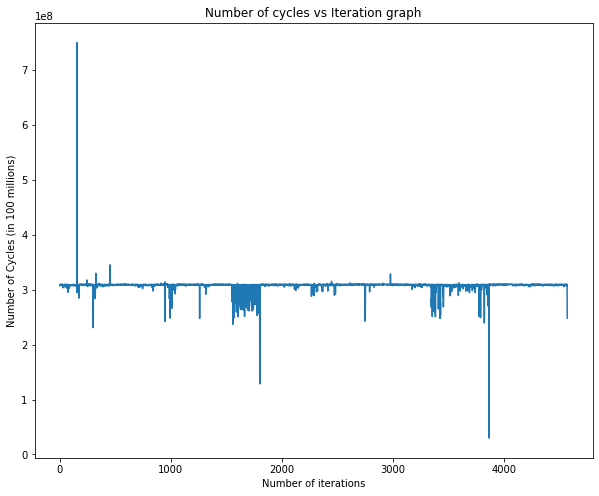

In [55]:
cycles = df_model.iloc[:, 1]
fix, ax = plt.subplots(figsize=(10, 8))
x_coord = [i for i in range(1, cycles.size+1)]
ax.plot(x_coord, cycles)
ax.set_xlabel("Number of iterations")
ax.set_ylabel("Number of Cycles (in 100 millions)")
ax.set_title("Number of cycles vs Iteration graph")
plt.show()

# Applying PCA

For our purpose, we want to retain 90% of the variance. So, we are finding the minimum number of principal components which can give us 90% of cumulative variance.

Optimal number of principal components : 12
Cumulative variance reserved : 0.9020902687148747


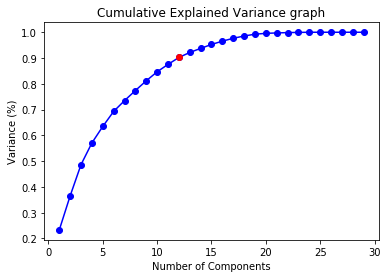

In [46]:
X = StandardScaler().fit_transform(df_model)
pca = PCA().fit(X)
#Plotting the Cumulative Summation of the Explained Variance
variance_list = np.cumsum(pca.explained_variance_ratio_)
optimal_n_components = 2
REQUIRED_VARIANCE = 0.9
for (i, variance) in enumerate(variance_list) :
    if(variance > REQUIRED_VARIANCE) :
        optimal_n_components = i+1
        break

pca = PCA(n_components=optimal_n_components)
X_pca = pca.fit_transform(X)
print("Optimal number of principal components :", optimal_n_components)
print("Cumulative variance reserved :", variance_list[optimal_n_components-1])

x_coord = list(range(1, variance_list.size+1))
plt.figure()
plt.plot(x_coord, variance_list, 'b')
plt.plot(x_coord, variance_list, 'ob')
plt.plot(optimal_n_components, variance_list[optimal_n_components-1], 'or')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Cumulative Explained Variance graph')
plt.show()

#Selecting the number of clusters with silhouette analysis on KMeans clustering

For n_clusters = 2 The average silhouette_score is : 0.3387080398085696
For n_clusters = 3 The average silhouette_score is : 0.33553951559143147
For n_clusters = 4 The average silhouette_score is : 0.3379390417637615
For n_clusters = 5 The average silhouette_score is : 0.16051975529202814
For n_clusters = 6 The average silhouette_score is : 0.1671082704130088

Optimal number of clusters ' 2  'with avg silhouette_score 0.3387080398085696 



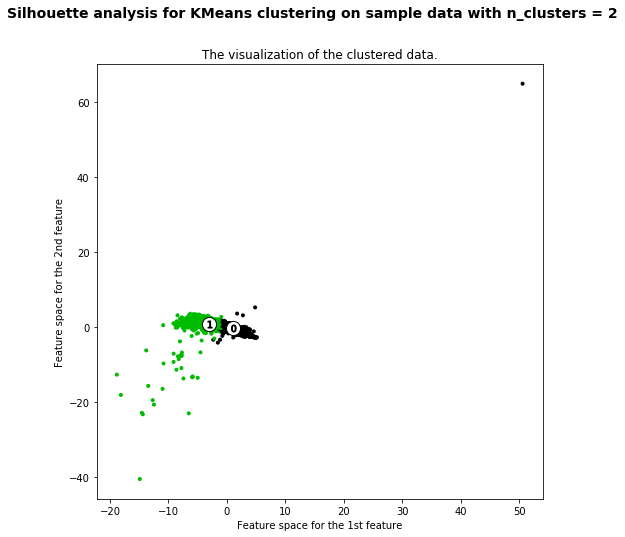

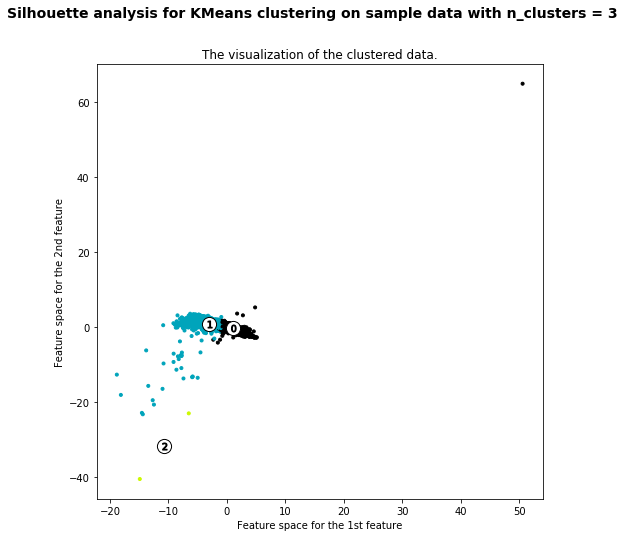

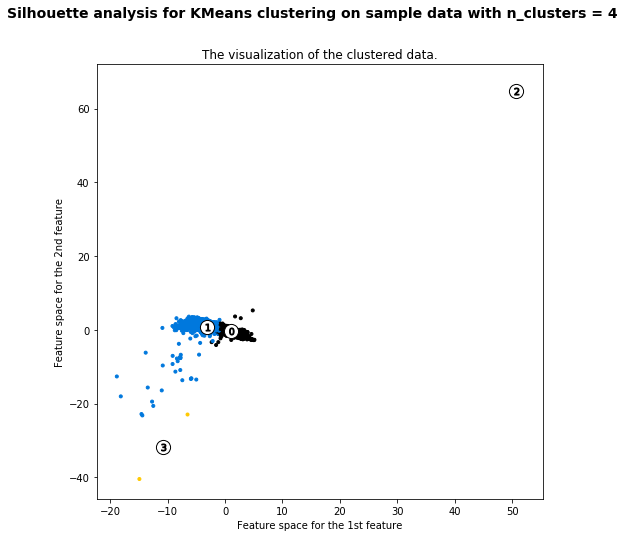

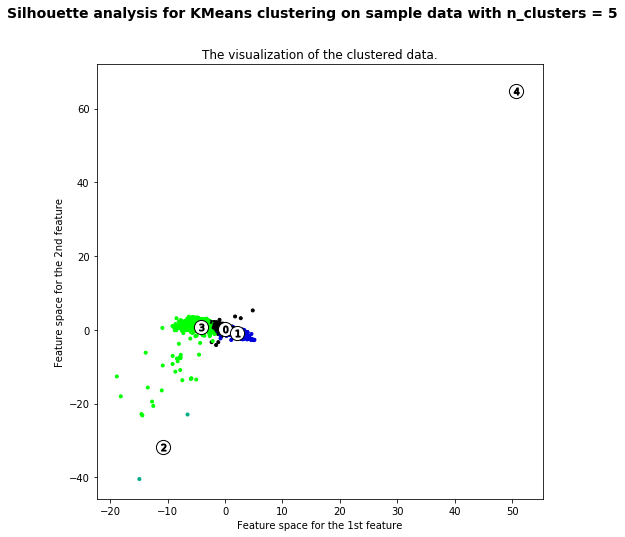

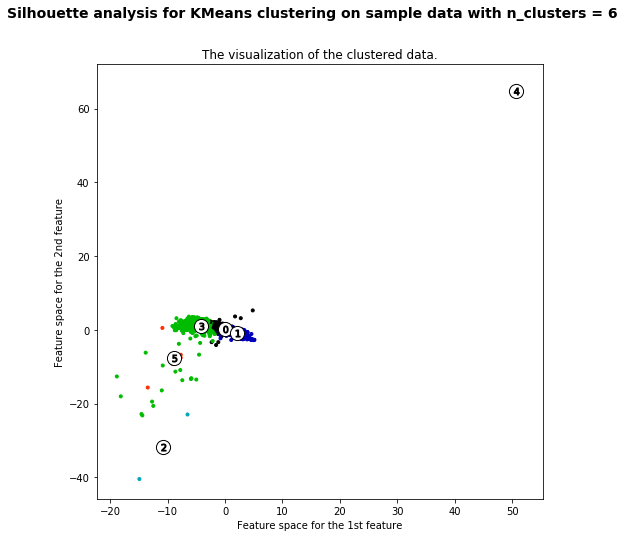

In [59]:
range_n_clusters = [2, 3, 4, 5, 6]
cluster_colors = ['r', 'b', 'g', 'y', 'c', 'm']
optimal_n_clusters = 2
best_silhoutte_avg = -1e8
for (i, n_clusters) in enumerate(range_n_clusters) :
    fig, ax = plt.subplots(figsize=(8,8))
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X_pca)
    # find silhouette avg
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_silhoutte_avg :
        best_silhoutte_avg = silhouette_avg
        optimal_n_clusters = n_clusters

    centers = clusterer.cluster_centers_
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', 
                c=colors)
    ax.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax.set_title("The visualization of the clustered data.")
    ax.set_xlabel("Feature space for the 1st feature")
    ax.set_ylabel("Feature space for the 2nd feature")
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
print("\nOptimal number of clusters '", optimal_n_clusters, " 'with avg silhouette_score", best_silhoutte_avg, "\n")
plt.show()

In [0]:
model = KMeans(n_clusters=optimal_n_clusters, random_state=42).fit(X_pca)

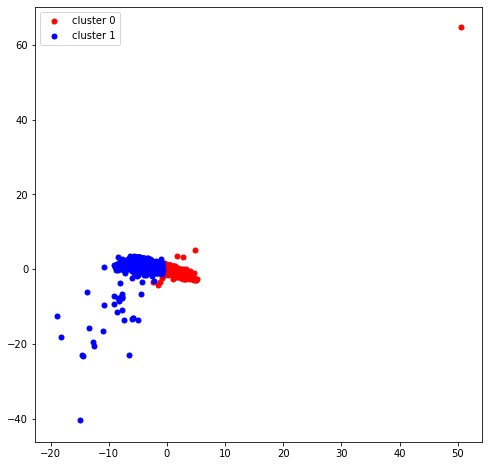

In [49]:
cluster_labels = model.labels_
fig, ax = plt.subplots(figsize=(8,8))
x_coord = X_pca[:,0]
y_coord = X_pca[:,1]
color_list = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'o']
for cluster_label in range(optimal_n_clusters) :
      ax.scatter(x_coord[cluster_labels==cluster_label], 
                        y_coord[cluster_labels==cluster_label],
                        s = 100,
                        marker = '.',
                        label='cluster ' + str(cluster_label),
                        c=color_list[cluster_label])
      
# uncomment to annotate the points
# for i in range(x_coord.size) :
#     ax.annotate(i, xy=(x_coord[i],y_coord[i]),  xytext=(0, 0),
#                      textcoords='offset points')
plt.legend()
plt.show()  

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
